## Introduction

Cheating Detection was the last problem in the qualification round of the Code Jam competition. The problem consists of finding a cheater among 100 players, given the answers they gave to 10.000 questions with different difficulties.

URL: https://codingcompetitions.withgoogle.com/codejam/round/000000000043580a/00000000006d1155

Unlike most programming problems the ability to pass a test case is not deterministic and therefore, the solution is evaluated based on the number of times it was able to correctly spot the cheater. 
To finish with the maximum number of points the solution must be able to find the cheater at least 86% of the time.

To analyze this problem, I divided this notebook in the following categories:

* [Input Analysis](#first-bullet)
* [Generating Input Data](#second-bullet)
* [Development Environment](#third-bullet)
* [Testing the Solution](#forth-bullet)


### Input Analysis <a class="anchor" id="first-bullet"></a>
From the looks of the input data of the data structure that comes to mind is the numpy array. The analysis of the input data can give us some tips on how to solve the problem.

In [1]:
%matplotlib notebook

import numpy as np
from scipy.special import expit, logit
import matplotlib.pyplot as plt

In [2]:
PLAYERS = 100
QUESTIONS = 10_000

M = np.zeros((PLAYERS, QUESTIONS))

Below, we read the sample file into a Numpy Matrix. Note that in the real problem we would read a line using the **input** function.

In [3]:
with open('sample.txt') as input_file:
    input_file.readline()
    input_file.readline()

    for i in range(100):
        line = input_file.readline()
        aux = list(line)[:QUESTIONS]
        M[i, :] = aux

M.shape

(100, 10000)

<IPython.core.display.Javascript object>


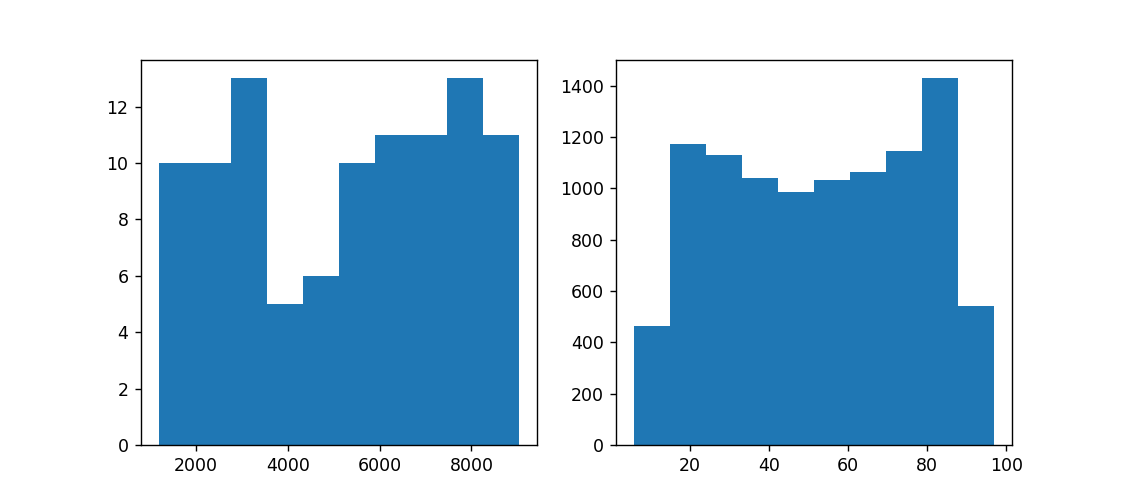

In [4]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(9,4))

ax1.hist(M.sum(axis = 1))
_=ax2.hist(M.sum(axis = 0))

The probability of a player solving the question is given by the sigmoid function bellow,

$$P(x) = \frac{1}{ 1 + e^{-x}},$$

where x is the difference between the skill of the player and the difficulty of the question.
To go from the probability to x we use the inverse of the sigmoid function defined as below,

$$x = \log(\frac{P}{1-P}),$$

where P is the probability. Looking at the graphs of both functions we can confirm they are the inverse of one another.

<IPython.core.display.Javascript object>


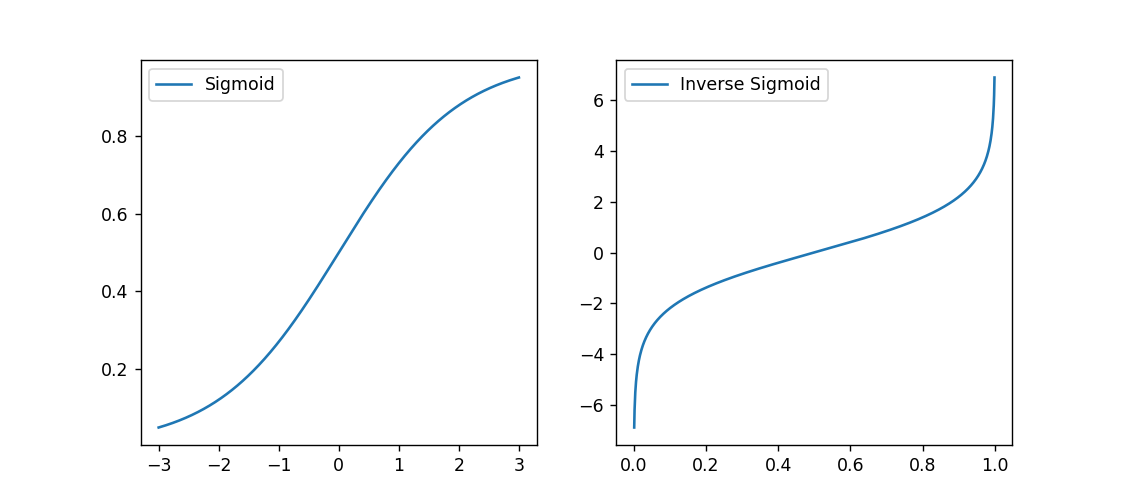

In [5]:
x_sigmoid = np.linspace(-3,3, 1000)
y_sigmoid = expit(x_sigmoid)

x_logit = np.linspace(0,1, 1000)
y_logit = logit(x_logit)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(9,4))

ax1.plot(x_sigmoid, y_sigmoid, label = "Sigmoid")
ax2.plot(x_logit, y_logit, label = "Inverse Sigmoid")

ax1.legend()
_ = ax2.legend()

To estimate the skill of the players and the difficulty of the questions we have to make some approximations.
The first is that the inverse of the sum of the probabilities (expected value) is the same as the skill and difficulty.


Below, we look at the distributions of the skills and difficulties estimated. As we can see the distributions look more like normal distributions than uniform ones, this means our estimations are not very accurate

Question Dificulty Shape: (10000,)
Player Skill Shape: (10000,)


<IPython.core.display.Javascript object>


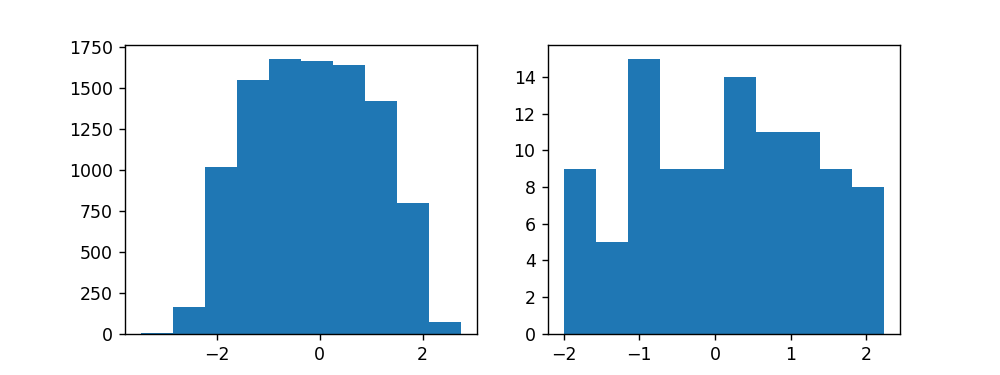

In [6]:
prob = M.mean(axis = 0)
difficulty = -logit(prob)
print(f"Question Dificulty Shape: {difficulty.shape}")

prob = M.mean(axis = 1)
skill = logit(prob)
print(f"Player Skill Shape: {difficulty.shape}")

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(8,3))

ax1.hist(difficulty)
_=ax2.hist(skill)

### Generating Input Data<a class="anchor" id="second-bullet"></a>

To test our hypothesis we have to generate our test set because, for this question, the sample data given in the problem is not enough for us to assume our solution will pass all the tests.

In [7]:
def generate():
    # Generate the skills and difficulties of the quesitons.
    questions = np.random.uniform(-3, 3, (1,10000))
    skills = np.random.uniform(-3, 3, (100,1))
    
    # Generate a random index for the cheater.
    ci = np.random.randint(100)

    # Calculate the probability of each each player for each question.
    prob = expit(skills- questions)
    
    # Generate another matrix to use it to pick the correct questions
    prob2 = np.random.random((100,10000))
    
    M = prob > prob2
    M = M.astype(int)
    
    # Generate the mask for the questions that the cheater will cheat. 
    cheater_mask = np.random.random(QUESTIONS) > 0.5
    
    # Update those questions to correct and leave the remaining with their old values.
    M[ci,:][cheater_mask] = 1
    
    return M, ci+1, skills, questions

Here we generate random input data and as we can see the distribution of the difficulties is uniform as it should be. The distribution of the skill of the players is also uniform but since the number of players is just 100, it is more susceptible to fluctuations

<IPython.core.display.Javascript object>


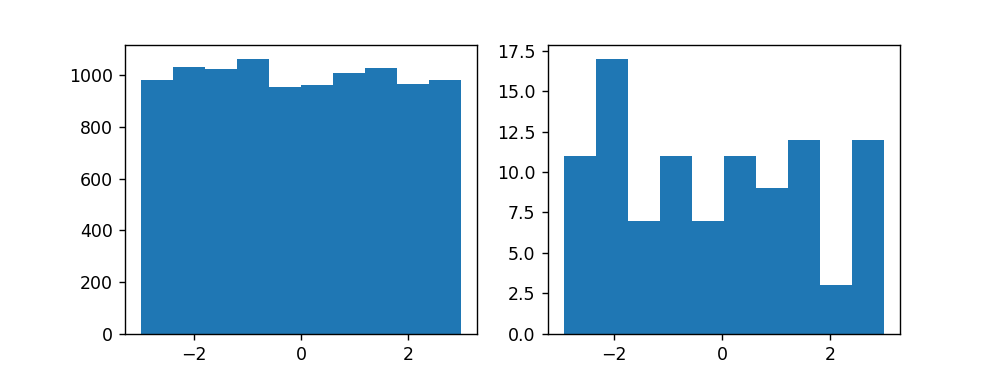

In [8]:
M, ci, real_skills, real_questions = generate()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(8,3))

ax1.hist(real_questions.flatten())
_=ax2.hist(real_skills)

Use the block below to generate 50 datasets and write them to files

In [9]:
cheaters = []
test_size = 50

with open("in.txt", "w") as f:
    
    f.write(str(test_size) + "\n")
    f.write("86\n")
    
    for i in range(test_size):
        answers, cheater, _, _ = generate()    
        cheaters.append(cheater)
        
        lines = ["".join(a.astype(str)) + "\n" for a in answers]
        f.writelines(lines)    

with open("out.txt", "w") as f:
    for i in range(1, test_size+1):
        case = f"Case #{i}: {cheaters[i-1]}\n"
        f.write(case)

### Development Environment<a class="anchor" id="third-bullet"></a>

We can use the functions above to generate data and test out solutions against it.

Develop your solution in the environment below.

In [10]:
M, ci, real_skills, real_questions = generate()

In [11]:

prob = M.mean(axis = 0)
difficulty = -logit(prob)

prob = M.mean(axis = 1)
skill = logit(prob)


extreme_question_mask = difficulty > 1.5
#extreme_question_mask |= question_skill < -1.5
e_len = extreme_question_mask.sum()

expected = np.sum(expit(skill.reshape((100,1)) - difficulty[extreme_question_mask].reshape(1,e_len)), axis = 1)

a = np.abs(expected - M[:, extreme_question_mask].sum(axis = 1))

a.argmax() + 1

97

In [12]:
# cheater index
ci

97

### Test the solution<a class="anchor" id="forth-bullet"></a>

When we are confident that our solution might be good enough to pass the 86% we can test it by comparing our results against the ones we generated.

In [13]:
def check_solution(solution):
    
    with open("in.txt", "r") as f:
        total = int(f.readline())
        minimum = int(f.readline())
        input_ = f.readlines() 
    
    with open("out.txt", "r") as f:
        correct = f.readlines()
    
    score = 0
    for idx in range(total):
        case = solution(input_[idx * PLAYERS: (idx + 1) * PLAYERS])
        
        if case == int(correct[idx].split(": ")[1]):
            score+=1
            
    print(f"Correct: {score} out of {total}.")
    print(f"Required to pass the test: {minimum}% Solution scored {score*100/total}%")
    
    return score*100/total

Below is the solution I found was good enough to find the cheater almost every time

In [14]:
import numpy as np
from scipy.special import expit, logit


def solution(game):
    PLAYERS = 100
    QUESTIONS = 10_000 

    M = np.zeros((PLAYERS, QUESTIONS))
    
    for i,line in enumerate(game):
        aux = list(line)[:QUESTIONS]
        M[i, :] = aux
        
    # Extimate the skill of every question.
    # Note that the difficulty is inversely proportional to the number of correct questions
    prob = M.mean(axis = 0)
    difficulty = -logit(prob)

    # Extimate the skill of every player
    prob = M.mean(axis = 1)
    skill = logit(prob)

    # The cheater will have at least half of the questions correct, as the number of questions increased
    player_mask = prob > 0.5
    p_len = player_mask.sum()
    
    # Create a mask representig the extreme questions
    extreme_question_mask = difficulty > 1.7
    extreme_question_mask |= difficulty < -1.7
    q_len = extreme_question_mask.sum()
    
    # Calculate the expected result using the sum of the probabilities (using the skills and difficulties calculated)
    probabilities = expit(skill[player_mask].reshape((p_len, 1)) - difficulty[extreme_question_mask].reshape(1,q_len))
    expected_result = np.sum(probabilities, axis = 1)
    
    # Calculate the difference between the expected result and the real result on extreme questions
    expected_diff = np.abs(expected_result - M[player_mask][:, extreme_question_mask].sum(axis = 1))
    
    # Get the index of the player with the highest difference
    idx_masked = np.argmax(expected_diff)
    
    # Unmask the index using the player_mask
    idx_unmasked = np.where(player_mask)[0][idx_masked]
    
    return idx_unmasked + 1

check_solution(solution)


Correct: 50 out of 50.
Required to pass the test: 86% Solution scored 100.0%


100.0